In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import random
from tqdm import trange

In [2]:
DEV = "cuda:0" if torch.cuda.is_available() else "cpu"
DEV = torch.device(DEV)
DEV

device(type='cuda', index=0)

## Load data

In [3]:
!wget https://raw.githubusercontent.com/ncarkaci/TDKDictionaryCrawler/master/ortak_kelimeler.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
with open("ortak_kelimeler.txt", encoding='utf-8') as f:
    text = f.read()

In [4]:
words = text.split("\n")

In [5]:
long_text = text.replace("\n","")
ids = list(set(long_text))
len(ids)

29

In [6]:
ordinal_char_pairs = sorted([(ord(c),c) for c in ids])
ordinal_char_pairs

[(97, 'a'),
 (98, 'b'),
 (99, 'c'),
 (100, 'd'),
 (101, 'e'),
 (102, 'f'),
 (103, 'g'),
 (104, 'h'),
 (105, 'i'),
 (106, 'j'),
 (107, 'k'),
 (108, 'l'),
 (109, 'm'),
 (110, 'n'),
 (111, 'o'),
 (112, 'p'),
 (114, 'r'),
 (115, 's'),
 (116, 't'),
 (117, 'u'),
 (118, 'v'),
 (121, 'y'),
 (122, 'z'),
 (231, 'ç'),
 (246, 'ö'),
 (252, 'ü'),
 (287, 'ğ'),
 (305, 'ı'),
 (351, 'ş')]

In [7]:
len(ordinal_char_pairs)

29

## Encode & Decode Functions

In [8]:
ctoi = {c:i for i,(o,c) in enumerate(ordinal_char_pairs)}
itoc =  {i:c for i,(o,c) in enumerate(ordinal_char_pairs)}

In [9]:
ctoi['.']=len(ctoi)
itoc[len(itoc)]='.'

In [10]:
def encode(input:str):
    return [ctoi[c] for c in input]

def decode(ids):
    return "".join([itoc[i] for i in ids])

In [11]:
assert decode(encode("zemberek"))=='zemberek'

## Helpers

In [13]:
def plot_training_loss(nn):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    axs[0].plot(nn.losses, label="Neural net train loss")
    axs[0].plot(nn.val_losses, label="Neural net val loss")
    axs[0].set_title('Losses')
    axs[0].legend()

    axs[1].plot([g[1] for g in nn.grads], label="Max")
    axs[1].plot([g[0] for g in nn.grads], label="Min")
    axs[1].plot([g[2] for g in nn.grads], label="Avg")
    axs[1].set_title('Gradients')
    axs[1].legend()

    plt.show()

## Prepare Training Data

In [14]:
def generate_data(words, block_size):
    xs, ys = [], []
    for w in words:
        context = [ctoi["."]]*block_size
        for c in w+'.':
            id = ctoi[c]

            xs.append(context)
            ys.append(id)

            context = context[1:]+[id]

    print(f"Generated {len(xs)} samples")

    xs = torch.tensor(xs, device=DEV)
    ys = torch.tensor(ys, device=DEV)

    return xs, ys

In [15]:
random.seed(13)
random.shuffle(words)

n = len(words)
n1 = int(n*0.8)
n2 = int(n*0.9)

## Train

In [16]:
class Trainer:
    def __init__(self) -> None:
        # for logging
        self.losses = []
        self.val_losses = []
        self.grads = []    

    def train(self, nn:nn.Module, xs, ys, xval=None, yval=None, lr=0.1, steps=1001, batch_size=None, print_steps=10):
        if steps>1:
            print(f"Model has {sum([p.nelement() for p in nn.parameters()])} parameters!")
            print(f"Using {len(xs)} samples")

        # set default loss value to zero
        loss = val_loss = torch.zeros((1))[0]

        # training loop
        for i in range(steps):
            bxs, bys = self.get_batch(xs, ys, batch_size)

            # FORWARD
            logits = nn(bxs)

            # loss: negative log likelihood
            loss = F.cross_entropy(logits, bys)
            
            # backward
            nn.zero_grad()
            loss.backward()

            # update weights
            for p in nn.parameters():
                p.data -= lr * p.grad

            # log validation loss
            if xval is not None:
                val_loss = self.evaluate(nn, xval, yval)

            # report losses
            if steps>1 and i % print_steps == 0:
                print(f"Step {i} | loss: {loss.item():.4f} | val loss: {val_loss.item():.4f}")

            _params = list(nn.parameters())
            # logging
            self.losses.append(loss.item())
            self.grads.append([
                min([p.grad.min().item() for p in _params]),
                max([p.grad.max().item() for p in _params]),
                sum([p.grad.mean().item() for p in _params])/len(_params)
            ]
            )

        if steps>1:
            print(f"loss: {loss.item():.4f} validation loss: {val_loss.item():.4f}")

        pass

    @torch.no_grad()
    def evaluate(self, nn, xval, yval):
        nn.train(False) # eval mode
        
        val_bxs, val_bys = self.get_batch(xval, yval, None)
        val_logits = nn(val_bxs)
        val_loss = F.cross_entropy(val_logits, val_bys)
                    
        self.val_losses.append(val_loss.item())
        
        nn.train(True) # back to train mode

        return val_loss

    def get_batch(self, xs, ys, batch_size):
        if batch_size is None:
            bxs = xs
            bys = ys
        else :
            ix = torch.randint(0, xs.shape[0], (batch_size,), device=DEV)
            bxs = xs[ix]
            bys = ys[ix]
        return bxs,bys

    def generate(self):
        reverse_offset = -self.block_size
        n_start_chars = self.block_size

        chars = torch.tensor([ctoi['.']]*n_start_chars, device=DEV).view(1,-1)

        while True:
            input = chars[:,reverse_offset:]
            logits = self.forward(input)
            probs = F.softmax(logits, dim=-1)
            assert probs.shape == (1, 30), f"{probs.shape=}"

            next_char = torch.multinomial(probs, 1, replacement=True, generator=self.g)

            if next_char.item() == ctoi['.']:
                return decode(list(chars.cpu()[0].numpy())[n_start_chars:])
        
            chars = torch.concat((chars, next_char), dim=-1)

In [17]:
def lr_search(nn, xs, ys, steps=1001):
        lre = torch.linspace(-3, 0, steps)
        lrs = 10**lre

        lri = []
        trainer = Trainer()
        for i in trange(steps):
            lr = lrs[i]
            
            trainer.train(nn, xs, ys, lr = lr, steps=1)
            
            lri.append(lre[i])

        plt.plot(lri, trainer.losses)

In [48]:
class MlpLM(nn.Module):
    def __init__(self, block_size, n_embd, hidden_size=100, vocab_size=30):
        super().__init__()

        self.block_size = block_size
        self.n_embd = n_embd
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.net = nn.Sequential(
            nn.Embedding(vocab_size, self.n_embd),
            nn.Flatten(1,2),
            nn.Linear(self.n_embd*self.block_size, hidden_size, bias=True),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )

    def forward(self, ix):
        return self.net(ix)



In [43]:
def test():
    input = torch.randint(0, 30, (32, 3))

    emb = nn.Embedding(30,10)
    flatten = nn.Flatten(1,2)
    print(flatten(emb(input)).shape)

    C = nn.Parameter(emb.weight)
    print(C[input].shape)
    print(C[input].view(-1, 30).shape)

    print( (C[input].view(-1, 30)== flatten(emb(input))).all())

test()


torch.Size([32, 30])
torch.Size([32, 3, 10])
torch.Size([32, 30])
tensor(True)


In [29]:
emb = nn.Embedding(30,10)

In [37]:
emb.weight.shape

torch.Size([30, 10])

## Context Length 3

In [46]:
block_size = 3
xs_train, ys_train = generate_data(words[:n1], block_size)
xs_valid, ys_valid = generate_data(words[n1:n2], block_size)
# xs_test, ys_test = generate_data(words[n2:], block_size)

Generated 293606 samples
Generated 36892 samples


100%|██████████| 1001/1001 [00:04<00:00, 214.92it/s]


CPU times: total: 4.55 s
Wall time: 4.69 s


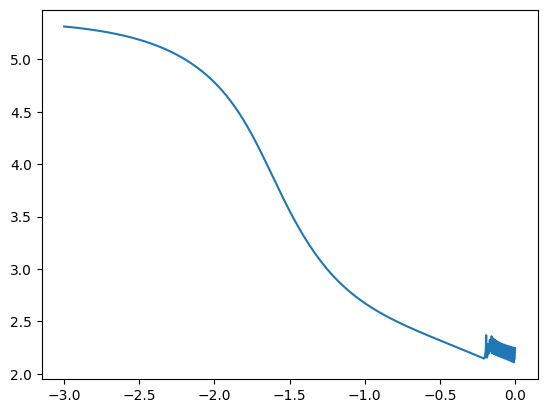

In [133]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.to(DEV)

lr_search(nn4, xs_train[:3000], ys_train[:3000], steps=1001)

In [20]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.to(DEV)
trainer = Trainer()
trainer.train(nn4, xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=256, steps=1001)

Model has 46700 parameters!
Using 293606 samples
Step 0 | loss: 5.3187 | val loss: 5.0535
Step 10 | loss: 3.3434 | val loss: 3.2780
Step 20 | loss: 2.8931 | val loss: 2.8914
Step 30 | loss: 2.7412 | val loss: 2.7840
Step 40 | loss: 2.6178 | val loss: 2.6706
Step 50 | loss: 2.5634 | val loss: 2.6162
Step 60 | loss: 2.5575 | val loss: 2.5590
Step 70 | loss: 2.7941 | val loss: 2.6290
Step 80 | loss: 2.5135 | val loss: 2.6283
Step 90 | loss: 2.5028 | val loss: 2.5491
Step 100 | loss: 2.4418 | val loss: 2.5040
Step 110 | loss: 2.4142 | val loss: 2.4593
Step 120 | loss: 2.2992 | val loss: 2.4756
Step 130 | loss: 2.4910 | val loss: 2.4410
Step 140 | loss: 2.4676 | val loss: 2.4481
Step 150 | loss: 2.2745 | val loss: 2.4466
Step 160 | loss: 2.4565 | val loss: 2.4508
Step 170 | loss: 2.5716 | val loss: 2.4498
Step 180 | loss: 2.1950 | val loss: 2.3919
Step 190 | loss: 2.4537 | val loss: 2.3966
Step 200 | loss: 2.3411 | val loss: 2.4119
Step 210 | loss: 2.4403 | val loss: 2.3968
Step 220 | loss:

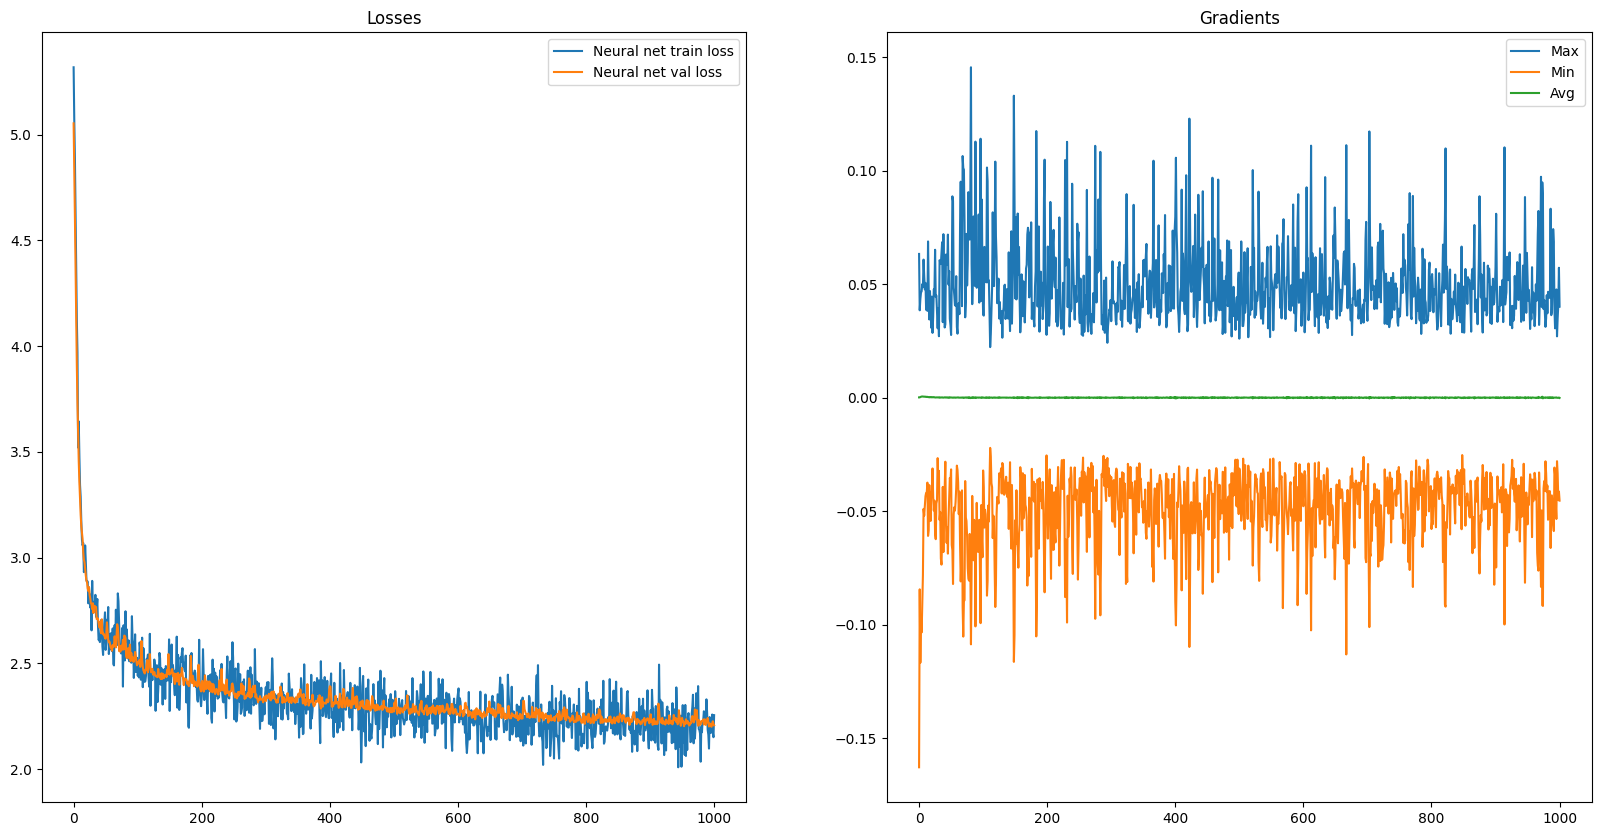

In [135]:
plot_training_loss(trainer)

In [136]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.to(DEV)
trainer = Trainer()
trainer.train(nn4, xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=1024, steps=1001)

Model has 46700 parameters!
Using 293606 samples
Step 0 | loss: 5.3062 | val loss: 5.0806
Step 10 | loss: 3.2847 | val loss: 3.2426
Step 20 | loss: 2.8404 | val loss: 2.8477
Step 30 | loss: 2.7391 | val loss: 2.7130
Step 40 | loss: 2.6649 | val loss: 2.6497
Step 50 | loss: 2.5486 | val loss: 2.5914
Step 60 | loss: 2.6338 | val loss: 2.5423
Step 70 | loss: 2.5123 | val loss: 2.5445
Step 80 | loss: 2.4588 | val loss: 2.4905
Step 90 | loss: 2.5000 | val loss: 2.5140
Step 100 | loss: 2.4038 | val loss: 2.4498
Step 110 | loss: 2.3987 | val loss: 2.4296
Step 120 | loss: 2.3956 | val loss: 2.4332
Step 130 | loss: 2.4200 | val loss: 2.4581
Step 140 | loss: 2.5195 | val loss: 2.4365
Step 150 | loss: 2.3029 | val loss: 2.3950
Step 160 | loss: 2.3487 | val loss: 2.3909
Step 170 | loss: 2.4441 | val loss: 2.4519
Step 180 | loss: 2.3158 | val loss: 2.3702
Step 190 | loss: 2.3831 | val loss: 2.3569
Step 200 | loss: 2.3478 | val loss: 2.3516
Step 210 | loss: 2.3370 | val loss: 2.3423
Step 220 | loss:

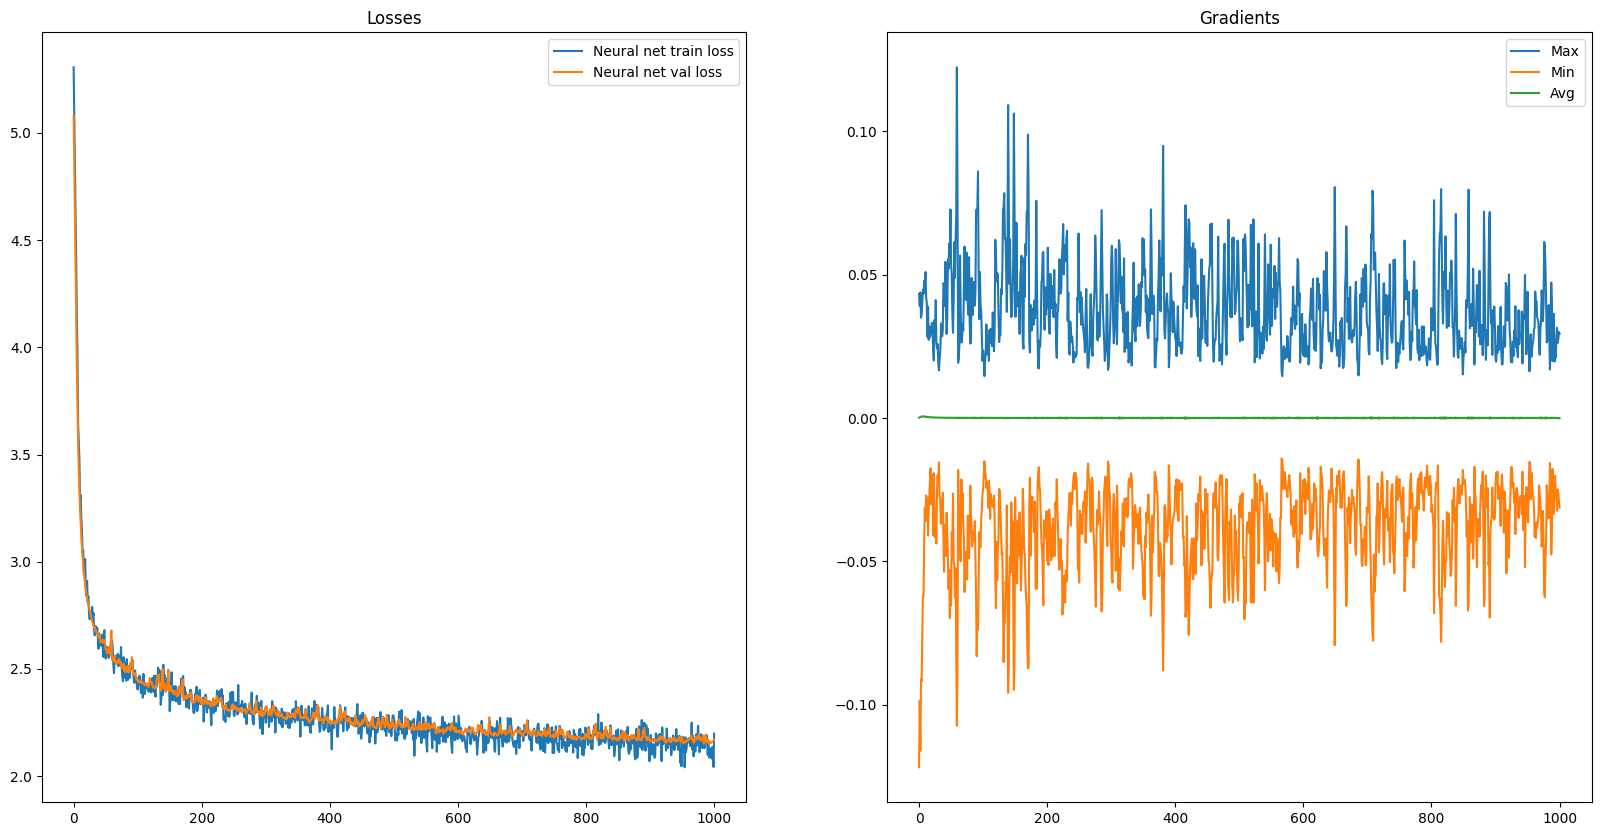

In [137]:
plot_training_loss(trainer)

In [145]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.to(DEV)
trainer = Trainer()
trainer.train(nn4, xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=8192, steps=1001)

Model has 46700 parameters!
Using 293606 samples
Step 0 | loss: 5.3019 | val loss: 5.0785
Step 10 | loss: 3.3164 | val loss: 3.2429
Step 20 | loss: 2.8730 | val loss: 2.8410
Step 30 | loss: 2.7240 | val loss: 2.6968
Step 40 | loss: 2.5863 | val loss: 2.6234
Step 50 | loss: 2.5676 | val loss: 2.6034
Step 60 | loss: 2.5199 | val loss: 2.5502
Step 70 | loss: 2.4874 | val loss: 2.5178
Step 80 | loss: 2.4481 | val loss: 2.4906
Step 90 | loss: 2.4304 | val loss: 2.4707
Step 100 | loss: 2.4547 | val loss: 2.4684
Step 110 | loss: 2.4267 | val loss: 2.4632
Step 120 | loss: 2.4028 | val loss: 2.4294
Step 130 | loss: 2.3825 | val loss: 2.4034
Step 140 | loss: 2.4102 | val loss: 2.3970
Step 150 | loss: 2.3784 | val loss: 2.4120
Step 160 | loss: 2.3669 | val loss: 2.3806
Step 170 | loss: 2.3697 | val loss: 2.3809
Step 180 | loss: 2.3373 | val loss: 2.3463
Step 190 | loss: 2.3509 | val loss: 2.3725
Step 200 | loss: 2.3507 | val loss: 2.3621
Step 210 | loss: 2.3251 | val loss: 2.3283
Step 220 | loss:

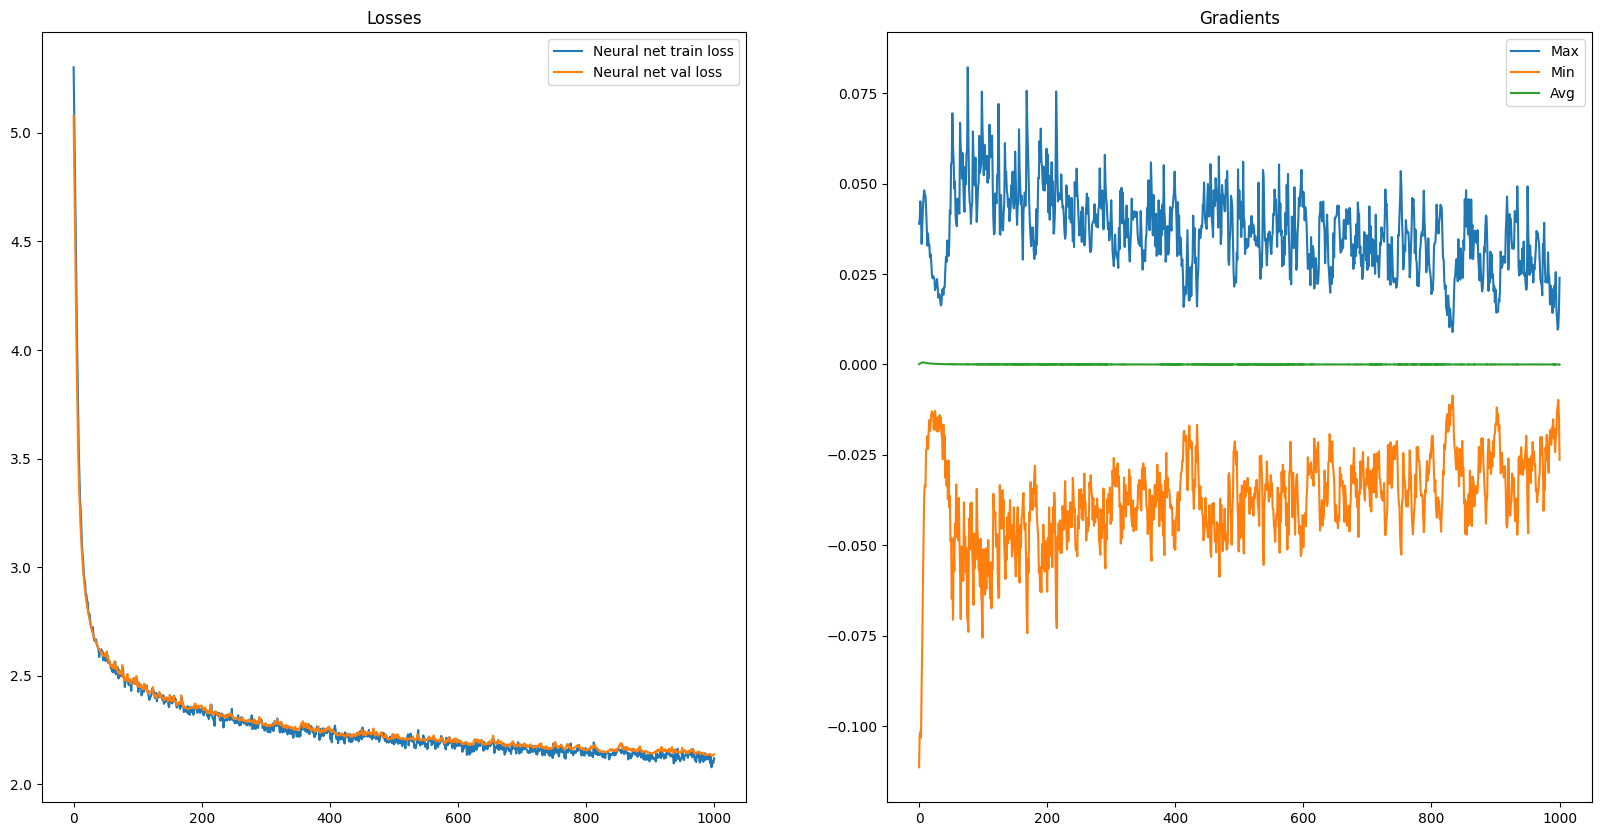

In [146]:
plot_training_loss(trainer)

In [143]:
%%time

torch.manual_seed(13)

nn4 = MlpLM(3, 10, hidden_size=200)
nn4.to(DEV)
trainer = Trainer()
trainer.train(nn4, xs_train, ys_train, xs_valid, ys_valid, 0.6, batch_size=None, steps=1001)

Model has 46700 parameters!
Using 293606 samples
Step 0 | loss: 5.3054 | val loss: 5.0773
Step 10 | loss: 3.3242 | val loss: 3.2419
Step 20 | loss: 2.8536 | val loss: 2.8391
Step 30 | loss: 2.6930 | val loss: 2.6915
Step 40 | loss: 2.6095 | val loss: 2.6126
Step 50 | loss: 2.5548 | val loss: 2.5601
Step 60 | loss: 2.5143 | val loss: 2.5206
Step 70 | loss: 2.4821 | val loss: 2.4893
Step 80 | loss: 2.4906 | val loss: 2.5323
Step 90 | loss: 2.4695 | val loss: 2.5067
Step 100 | loss: 2.4508 | val loss: 2.4806
Step 110 | loss: 2.4319 | val loss: 2.4574
Step 120 | loss: 2.4151 | val loss: 2.4379
Step 130 | loss: 2.4006 | val loss: 2.4213
Step 140 | loss: 2.3879 | val loss: 2.4068
Step 150 | loss: 2.3765 | val loss: 2.3940
Step 160 | loss: 2.3660 | val loss: 2.3825
Step 170 | loss: 2.3564 | val loss: 2.3720
Step 180 | loss: 2.3475 | val loss: 2.3624
Step 190 | loss: 2.3392 | val loss: 2.3534
Step 200 | loss: 2.3313 | val loss: 2.3451
Step 210 | loss: 2.3239 | val loss: 2.3373
Step 220 | loss:

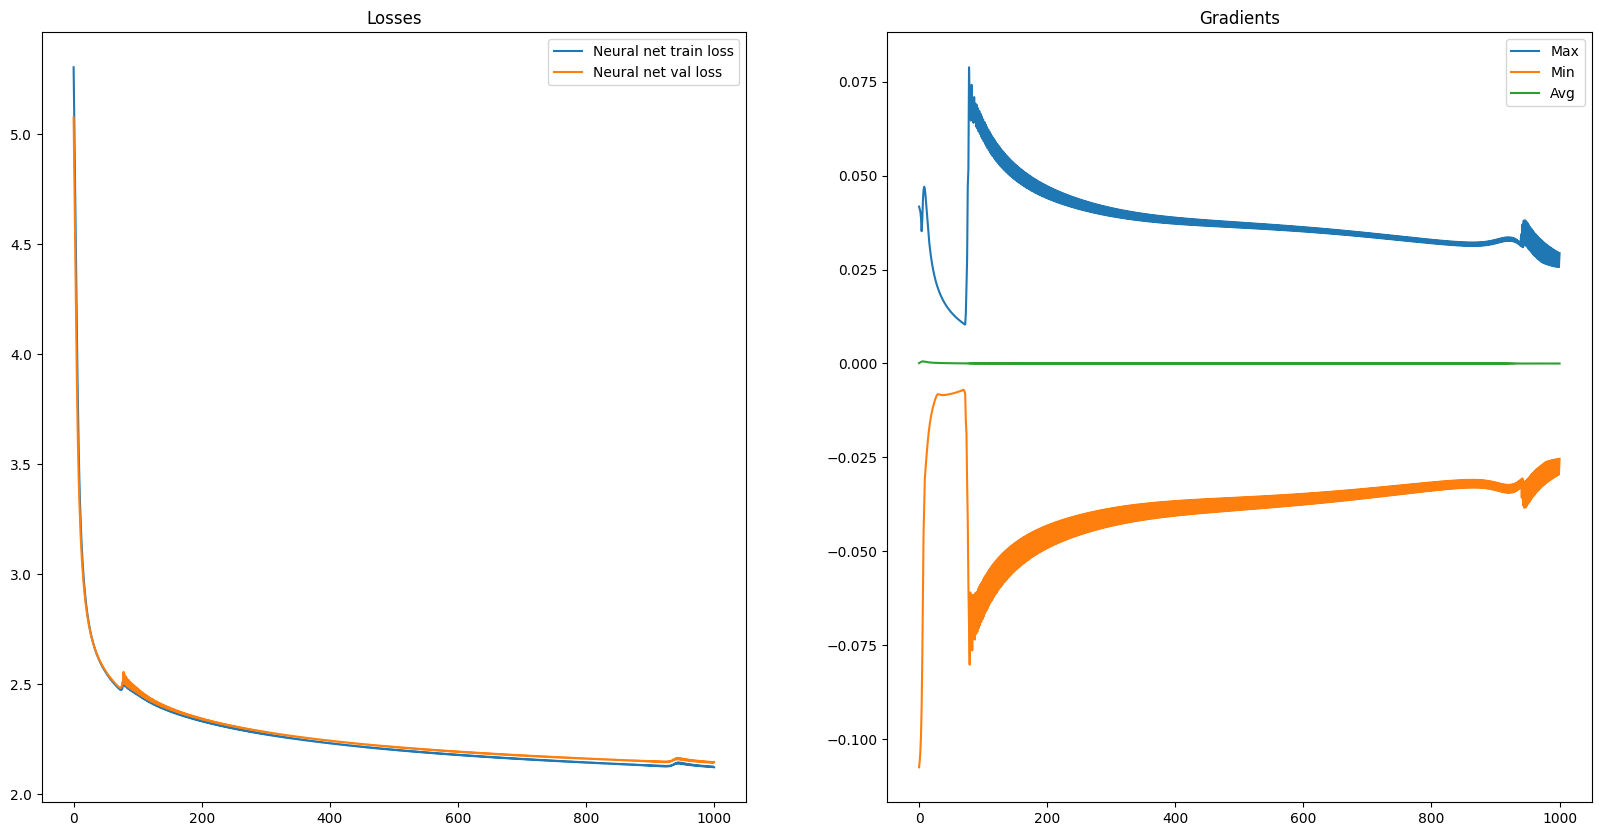

In [144]:
plot_training_loss(trainer)